# End-to-end ML Project

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, check_array
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Loading dataset

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data: pd.DataFrame = pd.read_csv("drive/MyDrive/datasets/housing/housing.csv")

In [4]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
data.ocean_proximity.value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [7]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

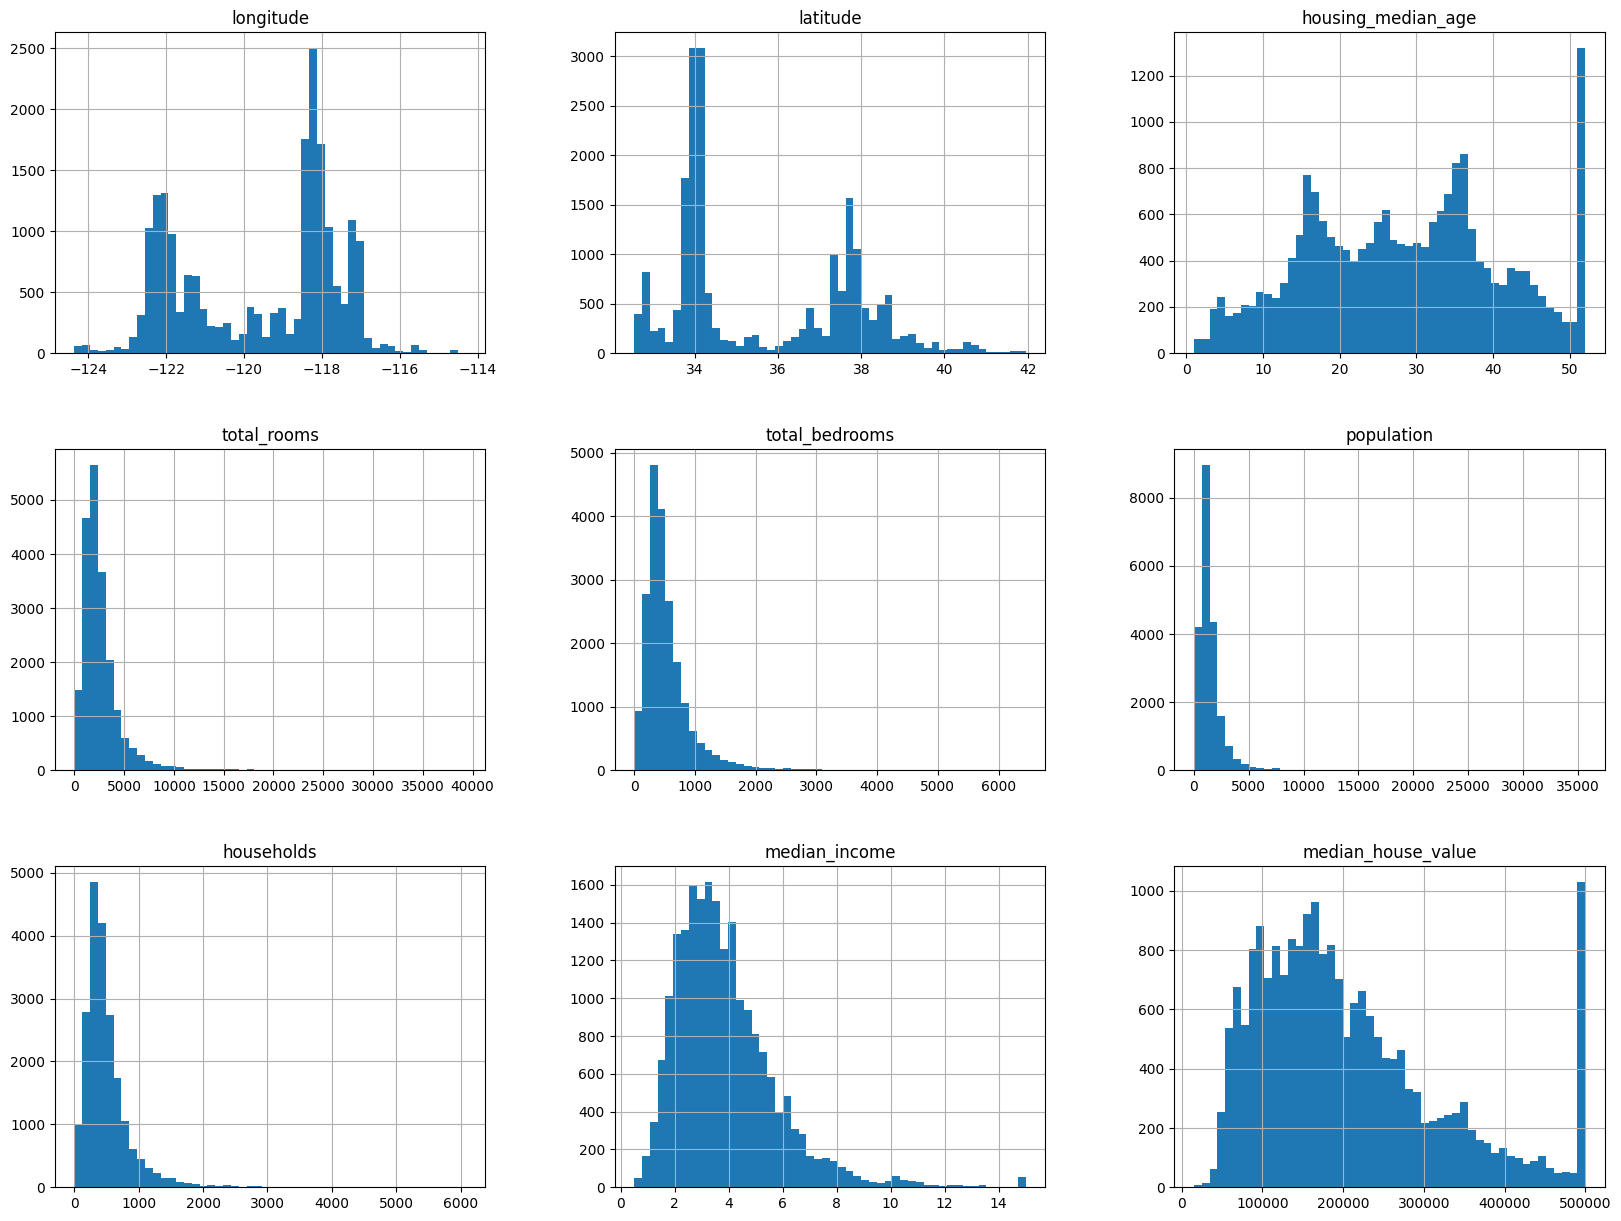

In [8]:
data.hist(bins=50, figsize=(20,15))

##Creating a test set

In [9]:
def shuffle_and_split(
        data: pd.DataFrame,
        *,
        test_ratio: float = 0.2,
        random_state: int = None
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Shuffle the data and split it into train and test sets using NumPy.
    """
    if random_state:
        np.random.seed(random_state)

    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train, test = shuffle_and_split(data, random_state= 42)

In [11]:
train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878,291000.0,NEAR OCEAN
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648,156100.0,NEAR OCEAN
17445,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875,353900.0,NEAR BAY
14265,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663,241200.0,<1H OCEAN
2271,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688,53800.0,INLAND


In [12]:
test.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-122.38,40.67,10.0,2281.0,444.0,1274.0,438.0,2.2120,65600.0,INLAND
3024,-118.37,33.83,35.0,1207.0,207.0,601.0,213.0,4.7308,353400.0,<1H OCEAN
15663,-117.24,32.72,39.0,3089.0,431.0,1175.0,432.0,7.5925,466700.0,NEAR OCEAN
20484,-118.44,34.05,18.0,4780.0,1192.0,1886.0,1036.0,4.4674,500001.0,<1H OCEAN
9814,-118.44,34.18,33.0,2127.0,414.0,1056.0,391.0,4.3750,286100.0,<1H OCEAN


###Splitting using sklearn

In [13]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

In [14]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878,291000.0,NEAR OCEAN
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648,156100.0,NEAR OCEAN
17445,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875,353900.0,NEAR BAY
14265,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663,241200.0,<1H OCEAN
2271,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688,53800.0,INLAND


In [15]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-122.38,40.67,10.0,2281.0,444.0,1274.0,438.0,2.2120,65600.0,INLAND
3024,-118.37,33.83,35.0,1207.0,207.0,601.0,213.0,4.7308,353400.0,<1H OCEAN
15663,-117.24,32.72,39.0,3089.0,431.0,1175.0,432.0,7.5925,466700.0,NEAR OCEAN
20484,-118.44,34.05,18.0,4780.0,1192.0,1886.0,1036.0,4.4674,500001.0,<1H OCEAN
9814,-118.44,34.18,33.0,2127.0,414.0,1056.0,391.0,4.3750,286100.0,<1H OCEAN


In [16]:
data["income_cat"] = pd.cut(
    data["median_income"],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)

<Axes: title={'center': 'Income Categories'}, xlabel='Categories', ylabel='Number of blocks'>

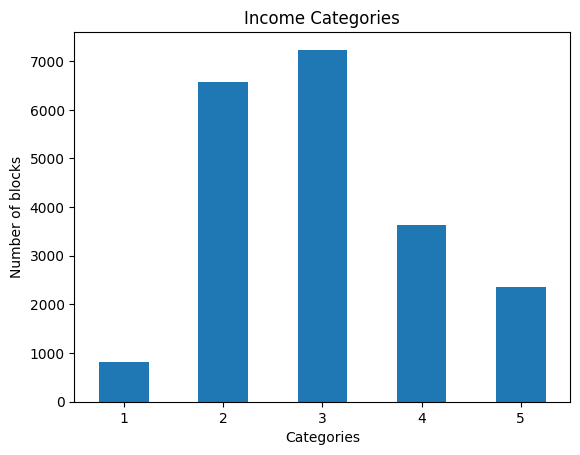

In [17]:
data["income_cat"].value_counts().sort_index().plot(
    kind= 'bar',
    title= "Income Categories",
    xlabel= "Categories",
    ylabel= "Number of blocks",
    rot= 0
)

In [18]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


In [19]:
strat_train_set, strat_test_set = train_test_split(data, test_size=0.2, stratify=data["income_cat"], random_state=42)

In [20]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,2
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,2
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,2
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3


In [21]:
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

In [22]:
splitter    #generator

StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.2,
            train_size=None)

In [23]:
#generating multiple train and test sets
strat_splits: list = []
for train_index, test_index in splitter.split(data, data["income_cat"]):
    strat_train_set_n = data.loc[train_index]
    strat_test_set_n = data.loc[test_index]
    strat_splits.append((strat_train_set_n, strat_test_set_n))

In [24]:
strat_splits[0]

(       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
 13096    -122.42     37.80                52.0       3321.0          1115.0   
 14973    -118.38     34.14                40.0       1965.0           354.0   
 3785     -121.98     38.36                33.0       1083.0           217.0   
 14689    -117.11     33.75                17.0       4174.0           851.0   
 20507    -118.15     33.77                36.0       4366.0          1211.0   
 ...          ...       ...                 ...          ...             ...   
 14207    -118.40     33.86                41.0       2237.0           597.0   
 13105    -119.31     36.32                23.0       2945.0           592.0   
 19301    -117.06     32.59                13.0       3920.0           775.0   
 19121    -118.40     34.06                37.0       3781.0           873.0   
 19888    -122.41     37.66                44.0        431.0           195.0   
 
        population  households  median

In [25]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


## Explore and Visulaize the Data to Gain Insights

In [26]:
housing = train.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

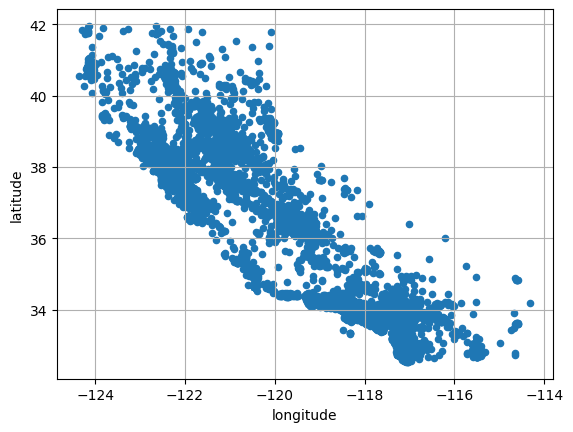

In [27]:
housing.plot(
    kind= 'scatter',
    x= 'longitude',
    y= 'latitude',
    grid= True
)

<Axes: xlabel='longitude', ylabel='latitude'>

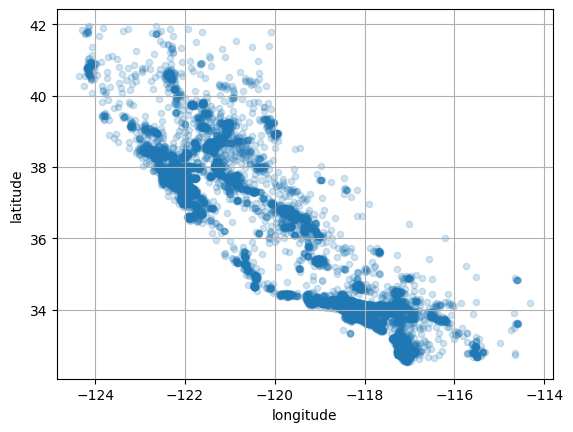

In [28]:
housing.plot(
    kind= 'scatter',
    x= 'longitude',
    y= 'latitude',
    grid= True,
    alpha= 0.2
)

<Axes: title={'center': 'California housing prices: red is expensive, blue is cheap, larger circles indicate areas with a larger population'}, xlabel='longitude', ylabel='latitude'>

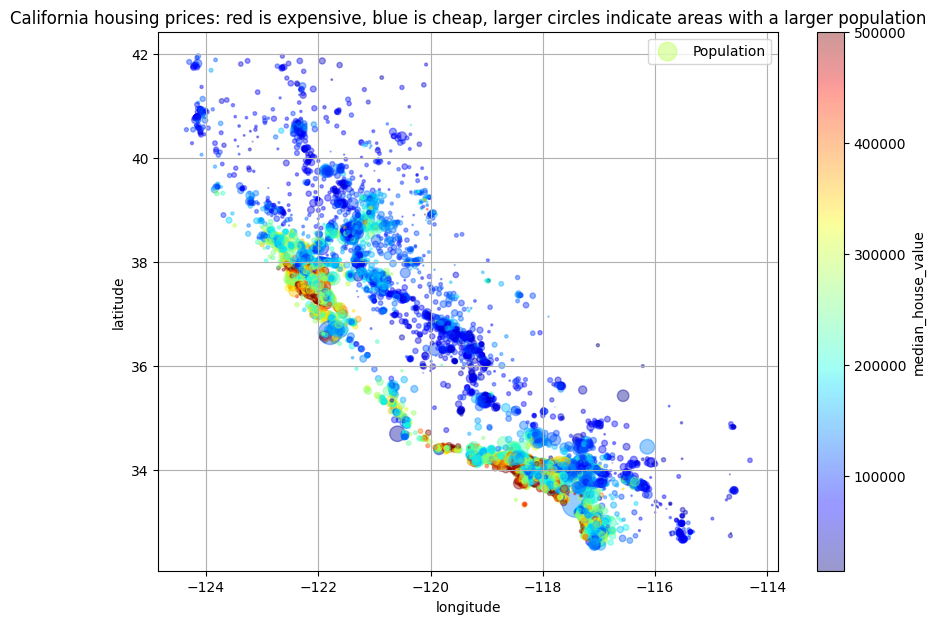

In [29]:
housing.plot(
    kind= 'scatter',
    x= 'longitude',
    y= 'latitude',
    title= "California housing prices: red is expensive, blue is cheap, larger circles indicate areas with a larger population",
    grid= True,
    s= housing['population'] / 100,     #radius of circles according to percentage of population
    c= 'median_house_value',            #color of circles accoding to median_house_value
    colormap= 'jet',                    #type of color set to use
    colorbar= True,
    alpha= 0.4,
    legend= True,
    figsize= (10, 7),
    label= 'Population'
)

In [30]:
corr_matrix = housing.corr(numeric_only= True)

In [31]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924341,-0.110786,0.043100,0.069439,0.100706,0.056318,-0.014592,-0.043603
latitude,-0.924341,1.000000,0.012640,-0.036327,-0.069283,-0.110514,-0.073915,-0.079259,-0.146324
housing_median_age,-0.110786,0.012640,1.000000,-0.362433,-0.318544,-0.291842,-0.301198,-0.118410,0.104714
total_rooms,0.043100,-0.036327,-0.362433,1.000000,0.928199,0.851766,0.916265,0.197326,0.134060
total_bedrooms,0.069439,-0.069283,-0.318544,0.928199,1.000000,0.873484,0.979627,-0.011782,0.049993
population,0.100706,-0.110514,-0.291842,0.851766,0.873484,1.000000,0.903045,0.000883,-0.025820
households,0.056318,-0.073915,-0.301198,0.916265,0.979627,0.903045,1.000000,0.009366,0.065798
median_income,-0.014592,-0.079259,-0.118410,0.197326,-0.011782,0.000883,0.009366,1.000000,0.687013
median_house_value,-0.043603,-0.146324,0.104714,0.134060,0.049993,-0.025820,0.065798,0.687013,1.000000


In [32]:
corr_matrix['median_house_value'].sort_values(ascending= False)

,median_house_value
median_house_value,1.000000
median_income,0.687013
total_rooms,0.134060
housing_median_age,0.104714
households,0.065798
total_bedrooms,0.049993
population,-0.025820
longitude,-0.043603
latitude,-0.146324


array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

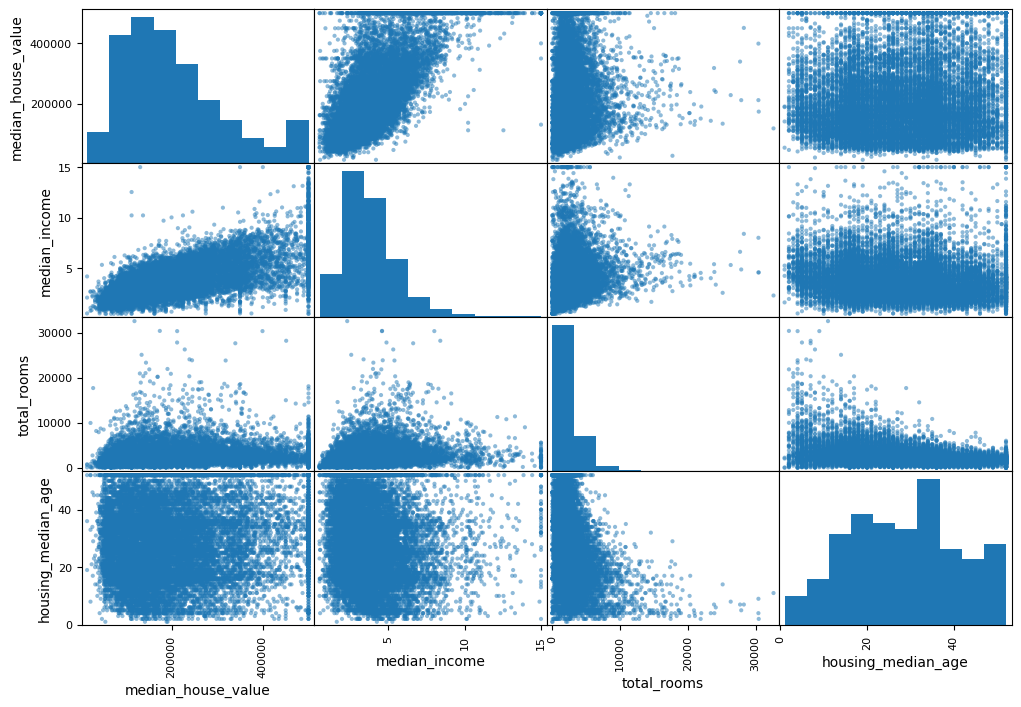

In [33]:
pd.plotting.scatter_matrix(
    housing[['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']],
    figsize= (12, 8)
)

<Axes: xlabel='median_income', ylabel='median_house_value'>

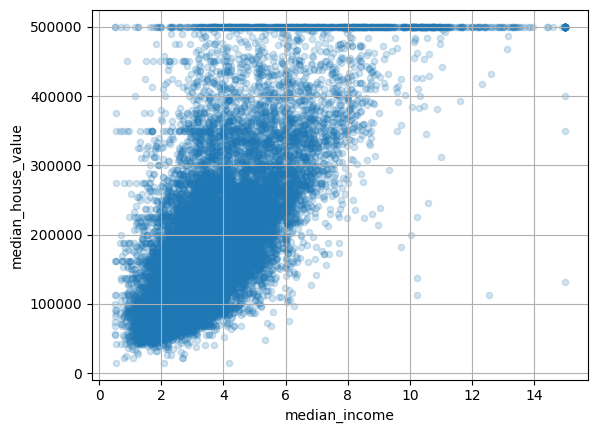

In [34]:
housing.plot(
    kind= 'scatter',
    x= 'median_income',
    y= 'median_house_value',
    alpha= 0.2,
    grid= True
)

In [35]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [36]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
14196,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878,291000.0,NEAR OCEAN,5.597948,0.185136,2.475746
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648,156100.0,NEAR OCEAN,5.395210,0.180910,4.179641
17445,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875,353900.0,NEAR BAY,4.655660,0.224924,2.004043
14265,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663,241200.0,<1H OCEAN,6.186154,0.157672,3.350769
2271,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688,53800.0,INLAND,10.000000,0.191667,2.625000


In [37]:
corr_matrix = housing.corr(numeric_only= True)

In [38]:
corr_matrix['median_house_value'].sort_values(ascending= False)

,median_house_value
median_house_value,1.000000
median_income,0.687013
rooms_per_household,0.146940
total_rooms,0.134060
housing_median_age,0.104714
households,0.065798
total_bedrooms,0.049993
population_per_household,-0.021577
population,-0.025820
longitude,-0.043603


array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='rooms_per_household', ylabel='median_house_value'>,
        <Axes: xlabel='bedrooms_per_room', ylabel='median_house_value'>,
        <Axes: xlabel='population_per_household', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='rooms_per_household'>,
        <Axes: xlabel='rooms_per_household', ylabel='rooms_per_household'>,
        <Axes: xlabel='bedrooms_per_room', ylabel='rooms_per_household'>,
        <Axes: xlabel='population_per_household', ylabel='rooms_per_household'>],
       [<Axes: xlabel='median_house_value', ylabel='bedrooms_per_room'>,
        <Axes: xlabel='rooms_per_household', ylabel='bedrooms_per_room'>,
        <Axes: xlabel='bedrooms_per_room', ylabel='bedrooms_per_room'>,
        <Axes: xlabel='population_per_household', ylabel='bedrooms_per_room'>],
       [<Axes: xlabel='median_house_value', ylabel='population_per_household'>,
        <Ax

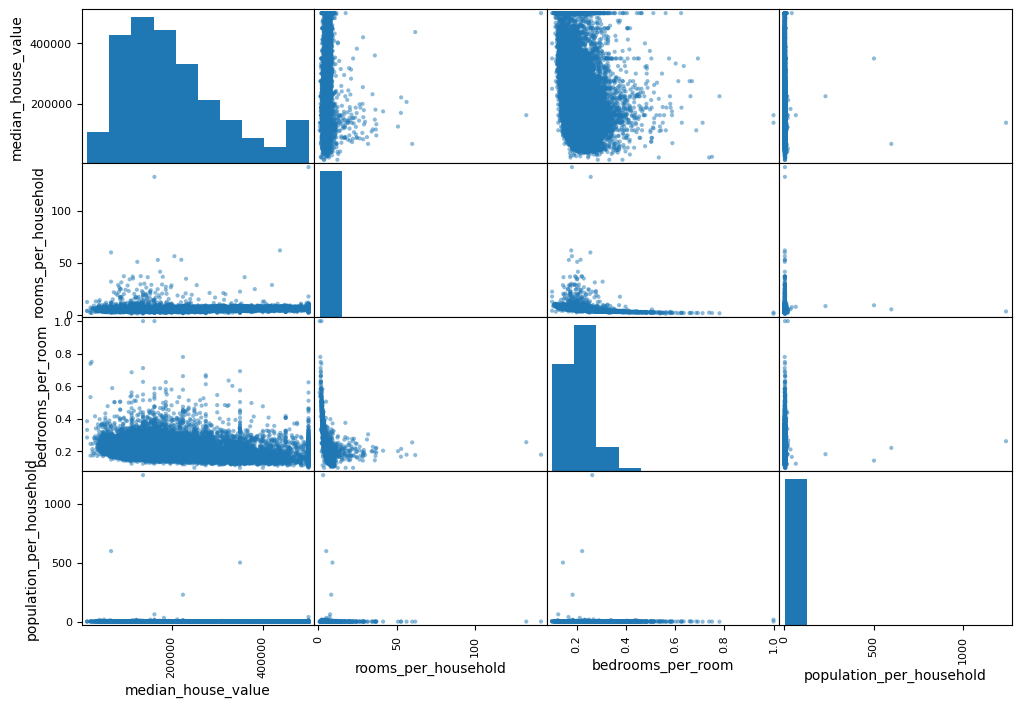

In [39]:
pd.plotting.scatter_matrix(
    housing[['median_house_value', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household']],
    figsize= (12, 8)
)

## Prepare the data for ML algorithm

In [40]:
features = train.drop('median_house_value', axis= 1)
labels = train['median_house_value'].copy()

In [41]:
features.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14196,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878,NEAR OCEAN
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648,NEAR OCEAN
17445,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875,NEAR BAY
14265,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663,<1H OCEAN
2271,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688,INLAND


In [42]:
labels.head()

,median_house_value
14196,291000.0
8267,156100.0
17445,353900.0
14265,241200.0
2271,53800.0


In [43]:
imputer = SimpleImputer(strategy= 'median')

In [44]:
numeric_features = features.select_dtypes(include= [np.number])

In [45]:
numeric_features.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14196,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648
17445,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875
14265,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663
2271,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688


In [46]:
imputer.fit(numeric_features)

SimpleImputer(strategy='median')

In [47]:
imputer.statistics_

array([-118.49  ,   34.25  ,   29.    , 2129.    ,  437.    , 1169.    ,
        411.    ,    3.5246])

In [48]:
np.array(numeric_features.median())     #same thing

array([-118.49  ,   34.25  ,   29.    , 2129.    ,  437.    , 1169.    ,
        411.    ,    3.5246])

In [49]:
X = imputer.transform(numeric_features)

In [50]:
X[0]

array([-1.1722e+02,  3.2750e+01,  3.4000e+01,  6.0010e+03,  1.1110e+03,
        2.6540e+03,  1.0720e+03,  4.5878e+00])

In [51]:
housing_tr = pd.DataFrame(
    X,
    columns= numeric_features.columns,
    index= numeric_features.index
)

In [52]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 14196 to 15795
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


### Handling text and categorical attributes

In [53]:
housing_cat = features[['ocean_proximity']]

In [54]:
housing_cat.value_counts()

,count
ocean_proximity,
<1H OCEAN,7313
INLAND,5276
NEAR OCEAN,2091
NEAR BAY,1827
ISLAND,5


In [55]:
ordinal_encoder = OrdinalEncoder()

In [56]:
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [57]:
housing_cat_encoded[:10]

array([[4.],
       [4.],
       [3.],
       [0.],
       [1.],
       [3.],
       [1.],
       [0.],
       [1.],
       [0.]])

In [58]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [59]:
encoder_1hot = OneHotEncoder()

In [60]:
housing_cat_1hot = encoder_1hot.fit_transform(housing_cat)

In [61]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [62]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [63]:
#pandas dummy variable
df_test = pd.DataFrame({'ocean_proximity': ['INLAND', 'ISLAND', '<2H OCEAN']})

In [64]:
pd.get_dummies(df_test, dtype= 'int32')

,ocean_proximity_<2H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND
0,0,1,0
1,0,0,1
2,1,0,0


In [65]:
encoder_1hot.handle_unknown = 'ignore'
encoder_1hot.transform(df_test).toarray()     #this is better because it remembers the features on which it is trained, and also ignore unknown

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [66]:
encoder_1hot.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [67]:
encoder_1hot.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [68]:
df_output = pd.DataFrame(
    encoder_1hot.transform(df_test).toarray(),
    columns= encoder_1hot.get_feature_names_out(),
    index= df_test.index
)

In [69]:
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0


###Feature Scaling and Transformations

In [70]:
min_max_scaler = MinMaxScaler(feature_range= (-1, 1))

In [71]:
housing_num_min_max_scaler = min_max_scaler.fit_transform(numeric_features)

In [72]:
housing_num_min_max_scaler[0]

array([ 0.42031873, -0.95536663,  0.29411765, -0.63224521, -0.65549348,
       -0.85139718, -0.6477553 , -0.4361595 ])

In [73]:
std_scaler = StandardScaler()

In [74]:
housing_num_std_scaled = std_scaler.fit_transform(numeric_features)

In [75]:
housing_num_std_scaled[0]

array([ 1.17299302, -1.35041487,  0.42853749,  1.57055658,  1.36798239,
        1.0810111 ,  1.50750741,  0.37969797])

Text(0, 0.5, 'Number of districts')

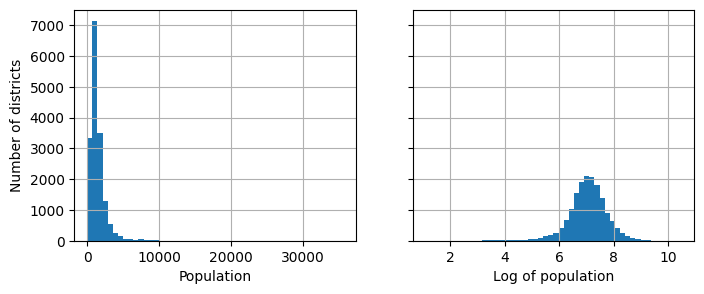

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")

In [77]:
age_similar_35 = rbf_kernel(housing[['housing_median_age']], [[35]])

In [78]:
age_similar_35

array([[3.67879441e-001],
       [3.68085585e-272],
       [5.24288566e-022],
       ...,
       [1.65841048e-157],
       [4.02006022e-074],
       [4.02006022e-074]])

In [79]:
label_scaler = StandardScaler()

In [80]:
scaled_labels = label_scaler.fit_transform(labels.to_frame())

In [81]:
scaled_labels

array([[ 0.73953621],
       [-0.43568808],
       [ 1.28750958],
       ...,
       [-0.88783145],
       [-1.0577119 ],
       [ 0.39454821]])

In [82]:
model1 = LinearRegression()

In [83]:
model1.fit(housing[['median_income']], scaled_labels)

LinearRegression()

In [84]:
scaled_predictions = model1.predict(housing.loc[:5, ['median_income']])

In [85]:
scaled_predictions

array([[ 0.26085752],
       [ 0.28859244],
       [-0.06342485],
       ...,
       [ 0.00973049],
       [-0.00039096],
       [ 0.0623908 ]])

In [86]:
label_scaler.inverse_transform(scaled_predictions)

array([[236054.10114638],
       [239237.69758773],
       [198830.83002753],
       ...,
       [207228.08245921],
       [206066.27648515],
       [213272.78115695]])

In [87]:
model2 = TransformedTargetRegressor(
    regressor= LinearRegression(),
    transformer= StandardScaler()
)

In [88]:
model2.fit(housing[['median_income']], labels)

TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=StandardScaler())

In [89]:
predictions = model2.predict(housing.loc[:5, ['median_income']])

In [90]:
predictions

array([236054.10114638, 239237.69758773, 198830.83002753, ...,
       207228.08245921, 206066.27648515, 213272.78115695])

###Custom Transformers

In [91]:
log_transformer = FunctionTransformer(np.log, inverse_func= np.exp)

In [92]:
log_transformer.transform(housing[['population']])

,population
14196,7.883823
8267,6.548219
17445,7.997663
14265,7.686162
2271,4.143135
...,...
11284,6.395262
11964,6.595781
5390,6.981935
860,7.356918


In [93]:
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args= {'gamma': 1.0, 'Y': [[35]]})

In [94]:
rbf_transformer.transform(housing[['housing_median_age']])

array([[3.67879441e-001],
       [3.68085585e-272],
       [5.24288566e-022],
       ...,
       [1.65841048e-157],
       [4.02006022e-074],
       [4.02006022e-074]])

In [95]:
sf_coords = 38, 118

In [96]:
sf_transformer = FunctionTransformer(rbf_kernel, kw_args= {'gamma': 1.0, 'Y': [sf_coords]})

In [97]:
sf_transformer.transform(housing[['latitude', 'longitude']])

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [98]:
ratio_transformer = FunctionTransformer(lambda X: X[:, 0] / X[:, 1])

In [99]:
ratio_transformer.transform(np.array([[1, 2], [3, 4]]))

array([0.5 , 0.75])

In [100]:
class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean: bool = True):
        self.with_mean: bool = with_mean

    def fit(self, X: np.ndarray | pd.DataFrame | pd.Series, y: np.ndarray | None = None) -> "StandardScalerClone":
        X = check_array(X)
        self.mean_ = X.mean(axis= 0)
        self.scale_ = X.std(axis= 0)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        check_is_fitted(self)
        X = check_array(X)
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [101]:
clone_scaler = StandardScalerClone()

In [102]:
clone_scaler.fit_transform(housing[['median_income']])

array([[ 0.37969797],
       [ 0.42006824],
       [-0.09231969],
       ...,
       [-0.91152173],
       [-0.63438241],
       [ 1.26207687]])

In [103]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(
            self,
            *,
            n_clusters: int = 10,
            gamma: float = 1.0,
            random_state: int | None = None
        ):
        self.n_clusters: int = n_clusters
        self.gamma: float = gamma
        self.random_state: int | None = random_state

    def fit(
            self,
            X: np.ndarray | pd.DataFrame | pd.Series,
            y: np.ndarray | None = None
        ) -> 'ClusterSimilarity':
        X = check_array(X)
        self.kmeans_ = KMeans(n_clusters= 10, random_state= self.random_state, n_init= 10)
        self.kmeans_.fit(X)
        return self

    def transform(self, X: np.ndarray | pd.DataFrame | pd.Series) -> 'rbf_kernel':
        check_is_fitted(self)
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma= self.gamma)

    def get_feature_names_out(self, names= None) -> np.ndarray:
        return np.asarray([f'Cluster {i} Similarity' for i in range(self.n_clusters)])

In [104]:
cluster_simil = ClusterSimilarity(random_state= 42)

In [105]:
similarities = cluster_simil.fit_transform(housing[['latitude', 'longitude']])

In [106]:
similarities[0]

array([2.15683721e-01, 2.78356969e-21, 5.46300485e-10, 8.81291648e-01,
       5.20347830e-19, 6.06013023e-02, 3.44210908e-46, 7.95918951e-24,
       3.00692617e-33, 2.55404432e-05])

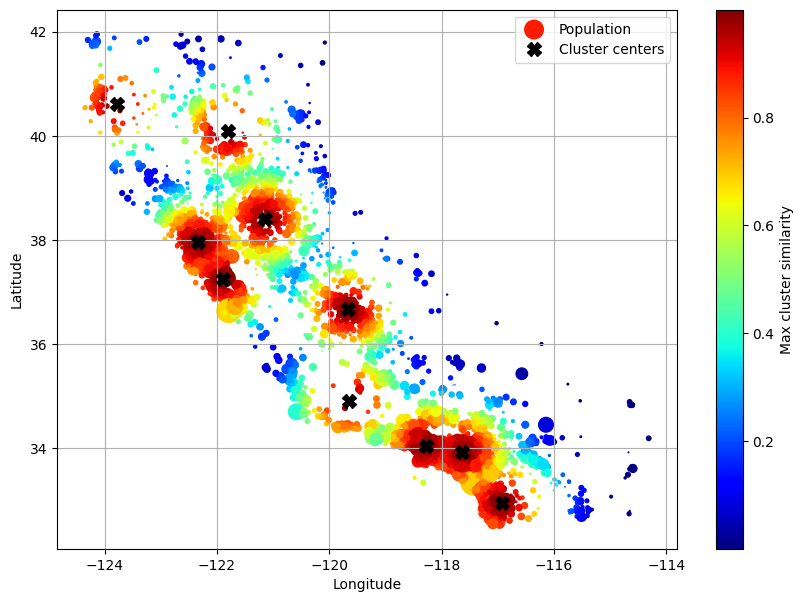

In [107]:
housing_renamed = housing.rename(
    columns= {
        "latitude": "Latitude",
        "longitude": "Longitude",
        "population": "Population",
        "median_house_value": "Median house value (ᴜsᴅ)"
    }
)
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(
    kind="scatter",
    x="Longitude",
    y="Latitude",
    grid=True,
    s=housing_renamed["Population"] / 100,
    label="Population",
    c="Max cluster similarity",
    cmap="jet",
    colorbar=True,
    legend=True,
    sharex=False,
    figsize=(10, 7)
)
plt.plot(
    cluster_simil.kmeans_.cluster_centers_[:, 1],
    cluster_simil.kmeans_.cluster_centers_[:, 0],
    linestyle="",
    color="black",
    marker="X",
    markersize=10,
    label="Cluster centers"
)
plt.legend(loc="upper right")

###Transformation Pipelines

In [108]:
my_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy= 'median')),
    ('standarize', StandardScaler()),
    ('regression', LinearRegression())
])

In [109]:
my_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standarize', StandardScaler()),
                ('regression', LinearRegression())])

In [110]:
pipeline2 = make_pipeline(SimpleImputer(strategy= 'median'), MinMaxScaler())

In [111]:
pipeline2

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('minmaxscaler', MinMaxScaler())])

In [112]:
my_pipeline.fit(housing[['median_income']], housing[['median_house_value']])

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standarize', StandardScaler()),
                ('regression', LinearRegression())])

In [113]:
my_pipeline.predict([[12]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


array([[542514.53676463]])

In [114]:
my_pipeline.steps

[('impute', SimpleImputer(strategy='median')),
 ('standarize', StandardScaler()),
 ('regression', LinearRegression())]

In [115]:
my_pipeline['impute']

SimpleImputer(strategy='median')

In [116]:
num_attributes = train.columns.delete([8, 9])

In [117]:
cat_attributes = train['ocean_proximity']

In [118]:
num_pipeline = make_pipeline(
    SimpleImputer(strategy= 'median'),
    StandardScaler()
)
cat_pipeline = make_pipeline(
    SimpleImputer(strategy= 'most_frequent'),
    OneHotEncoder(handle_unknown= 'ignore')
)

In [119]:
column_transformer = ColumnTransformer([
    ('num', num_pipeline, num_attributes),
    ('cat', cat_pipeline, cat_attributes)
])

In [120]:
column_transformer

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 14196    NEAR OCEAN
8267     NEAR OCEAN
17445      NEAR BAY
14265     <1H OCEAN
2271         INLAND
            ...    
11284      NEAR BAY
11964     <1H OCEAN
5390         INLAND
860          INLAND
15795     <1H OCEAN
Name: ocean_proximity, Length: 16512, dtype: object)])

In [121]:
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include= 'float64')),
    (cat_pipeline, make_column_selector(dtype_include= 'object'))
)

In [122]:
preprocessing

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f5ef50b9c90>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f5ef50ba6b0>)])

###Using above mentioned techniques to prepare housing data

In [123]:
def ratio_name(function_transformer, feature_names_in):
    return ['ratio']

ratio_pipeline = make_pipeline(
    (SimpleImputer(strategy= 'median')),
    (FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]], feature_names_out= ratio_name)),
    (StandardScaler())
)

In [124]:
log_pipeline = make_pipeline(
    (SimpleImputer(strategy= 'median')),
    (FunctionTransformer(np.log, feature_names_out= 'one-to-one', inverse_func= np.exp)),
    (StandardScaler())
)

In [125]:
cluster_simil = ClusterSimilarity(random_state= 42)

In [126]:
default_num_pipeline = make_pipeline(
    (SimpleImputer(strategy= 'median')),
    (StandardScaler())
)

In [127]:
cat_pipeline = make_pipeline(
    (SimpleImputer(strategy= 'most_frequent')),
    (OneHotEncoder(handle_unknown= 'ignore'))
)

In [128]:
features.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14196,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878,NEAR OCEAN
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648,NEAR OCEAN
17445,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875,NEAR BAY
14265,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663,<1H OCEAN
2271,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688,INLAND


In [129]:
preprocessing = ColumnTransformer([
    ('bedrooms', ratio_pipeline, ['total_bedrooms', 'total_rooms']),
    ('rooms_per_house', ratio_pipeline, ['total_rooms', 'households']),
    ('people_per_house', ratio_pipeline, ['population', 'households']),
    ('geo', cluster_simil, ['latitude', 'longitude']),
    ('log', log_pipeline, ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']),
    ('cat', cat_pipeline, make_column_selector(dtype_include= 'object'))
    ],
    remainder= default_num_pipeline
)

In [130]:
preprocessing

ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                             SimpleImputer(strategy='median')),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('bedrooms',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function ratio_name at 0x7f5ef50cb010>,
                                                                      func=<function <lambda> at 0x...
                                                                      inverse_func=<ufunc 'exp'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f5ef50bb940>)])

In [131]:
housing_prepared = preprocessing.fit_transform(features)

In [132]:
housing_prepared_df = pd.DataFrame(
    housing_prepared,
    columns= preprocessing.get_feature_names_out()
)

In [133]:
housing_prepared_df

,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,geo__Cluster 0 Similarity,geo__Cluster 1 Similarity,geo__Cluster 2 Similarity,geo__Cluster 3 Similarity,geo__Cluster 4 Similarity,geo__Cluster 5 Similarity,geo__Cluster 6 Similarity,...,log__total_bedrooms,log__population,log__households,log__median_income,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
0,-0.435849,0.064362,-0.053642,2.156837e-01,2.783570e-21,5.463005e-10,8.812916e-01,5.203478e-19,6.060130e-02,3.442109e-46,...,1.316154,1.162476,1.356761,0.597466,0.0,0.0,0.0,0.0,1.0,0.428537
1,-0.499798,-0.014850,0.093497,1.540766e-01,3.053787e-22,1.295691e-10,9.238842e-01,4.934067e-20,3.334603e-02,1.066104e-47,...,-1.319314,-0.648937,-1.181119,0.632869,0.0,0.0,0.0,0.0,1.0,-1.473509
2,0.166271,-0.303803,-0.094376,2.057442e-16,1.837971e-01,3.578688e-04,4.449547e-23,6.831974e-01,1.439054e-13,2.838283e-05,...,1.776949,1.316871,1.800671,0.132814,0.0,0.0,0.0,1.0,0.0,-0.046974
3,-0.851460,0.294183,0.021920,3.636314e-13,1.700678e-01,6.854978e-03,3.820168e-19,9.946061e-01,1.252195e-10,2.835773e-07,...,0.545854,0.894398,0.673852,0.850063,1.0,0.0,0.0,0.0,0.0,-0.284730
4,-0.337017,1.784306,-0.040754,4.567431e-02,1.593295e-23,1.717350e-11,3.558722e-01,1.265165e-22,2.999508e-03,3.548844e-50,...,-3.056517,-3.910834,-3.829087,-1.825116,0.0,1.0,0.0,0.0,0.0,-1.632013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.338821,-0.181286,-0.002171,1.678053e-17,1.817680e-01,1.316727e-04,2.141931e-24,4.956349e-01,1.406773e-14,1.147192e-04,...,-0.852477,-0.856386,-0.969540,-2.057636,0.0,0.0,0.0,1.0,0.0,1.617317
16508,-0.428797,0.103735,-0.064833,5.709021e-01,7.015391e-13,8.542708e-05,5.031415e-02,5.408862e-11,9.651956e-01,5.919738e-33,...,-0.350763,-0.584432,-0.327997,1.362764,1.0,0.0,0.0,0.0,0.0,0.507789
16509,-0.198219,-0.151231,-0.088581,2.112252e-04,4.133640e-04,7.689837e-01,4.823293e-08,5.452239e-04,2.266996e-03,1.943727e-17,...,0.292026,-0.060711,0.369267,-1.039551,0.0,1.0,0.0,0.0,0.0,-0.997998
16510,0.166961,-0.171637,0.006488,8.013585e-01,1.255984e-15,2.698470e-06,2.615353e-01,1.060251e-14,3.060259e-01,4.654814e-38,...,0.363112,0.447861,0.299253,-0.567043,0.0,1.0,0.0,0.0,0.0,-0.522486


In [134]:
housing_prepared_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   bedrooms__ratio                  16512 non-null  float64
 1   rooms_per_house__ratio           16512 non-null  float64
 2   people_per_house__ratio          16512 non-null  float64
 3   geo__Cluster 0 Similarity        16512 non-null  float64
 4   geo__Cluster 1 Similarity        16512 non-null  float64
 5   geo__Cluster 2 Similarity        16512 non-null  float64
 6   geo__Cluster 3 Similarity        16512 non-null  float64
 7   geo__Cluster 4 Similarity        16512 non-null  float64
 8   geo__Cluster 5 Similarity        16512 non-null  float64
 9   geo__Cluster 6 Similarity        16512 non-null  float64
 10  geo__Cluster 7 Similarity        16512 non-null  float64
 11  geo__Cluster 8 Similarity        16512 non-null  float64
 12  geo__Cluster 9 Sim

##Select and Train a Model

In [135]:
lin_reg = make_pipeline(
    preprocessing,
    LinearRegression()
)

In [136]:
lin_reg.fit(features, labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f5...
                                                                   StandardScaler())]),
                                                  ['total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5ef50bb940>)])),
                ('linearregression', LinearRegression())])

In [137]:
#checking on training data
predictions = lin_reg.predict(features)

In [138]:
predictions

array([263610.09927637, 199912.34510022, 275859.06569561, ...,
        97396.1057908 ,  88554.89241709, 301501.48611295])

In [139]:
lin_rmse = mean_squared_error(labels, predictions, squared= False)

In [140]:
lin_rmse

68743.64454430668

In [141]:
decision_tree = make_pipeline(
    preprocessing,
    DecisionTreeRegressor(random_state= 42)
)

In [142]:
decision_tree.fit(features, labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f5...
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5ef50bb940>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [143]:
decision_tree_predictions = decision_tree.predict(features)

In [144]:
decision_tree_predictions

array([291000., 156100., 353900., ..., 104200.,  84700., 251400.])

In [145]:
tree_rmse = mean_squared_error(labels, decision_tree_predictions, squared= False)

In [146]:
tree_rmse

0.0

###Better Evaluating using Cross-Validation

In [147]:
tree_rmses = -cross_val_score(decision_tree, features, labels, scoring= 'neg_root_mean_squared_error', cv= 10)

In [148]:
pd.Series(tree_rmses).describe()

,0
count,10.000000
mean,65887.161321
std,2230.509164
min,62847.855190
25%,64403.509799
50%,65117.619344
75%,67535.997279
max,69240.212422


In [149]:
forest_reg = make_pipeline(
    preprocessing,
    RandomForestRegressor(random_state= 42)
)

In [150]:
forest_reg.fit(features, labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f5...
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5ef50bb940>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [151]:
forest_rmses = -cross_val_score(forest_reg, features, labels, scoring= 'neg_root_mean_squared_error')

In [152]:
pd.Series(forest_rmses).describe()

,0
count,5.000000
mean,46962.515554
std,309.272334
min,46507.227920
25%,46825.354121
50%,47000.154942
75%,47215.694327
max,47264.146461


In [153]:
predictions_forest = forest_reg.predict(features)

In [154]:
forest_rmse = mean_squared_error(labels, predictions_forest, squared= False)

In [155]:
forest_rmse

17492.80307590959

##Fine-Tune Your Model
###Grid Search

In [156]:
full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest', RandomForestRegressor(random_state= 42))
])

In [157]:
param_grid = [
    {
        'preprocessing__geo__n_clusters': [5, 8, 10],
        'random_forest__max_features': [4, 6, 8]
    },
    {
        'preprocessing__geo__n_clusters': [10, 15],
        'random_forest__max_features': [6, 8, 10]
    },
]

In [158]:
grid_search = GridSearchCV(full_pipeline, param_grid= param_grid, cv= 3, scoring= 'neg_root_mean_squared_error')

In [159]:
grid_search.fit(features, labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f5ef50bb940>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [160]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 5, 'random_forest__max_features': 4}

In [161]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7f5ef50...
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5ef51674c0>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=4, random_state=42))])

In [162]:
cv_res = pd.DataFrame(grid_search.cv_results_)

In [163]:
cv_res.sort_values(by= 'mean_test_score', ascending= False, inplace= True)

In [164]:
cv_res = cv_res.loc[:, [
        "param_preprocessing__geo__n_clusters",
        "param_random_forest__max_features",
        "split0_test_score",
        "split1_test_score",
        "split2_test_score",
        "mean_test_score"
]]

score_cols = ["split0", "split1", "split2", "mean_test_rmse"]

cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

In [165]:
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
0,5,4,44846,45645,44968,45153
3,8,4,44846,45645,44968,45153
6,10,4,44846,45645,44968,45153
1,5,6,44824,45548,45195,45189
4,8,6,44824,45548,45195,45189


###Randomized Search

In [166]:
from scipy.stats import randint
param_distribution = {
    'preprocessing__geo__n_clusters': randint(3, 50),
    'random_forest__max_features': randint(2, 20)
}

In [167]:
rnd_search = RandomizedSearchCV(
    estimator= full_pipeline,
    param_distributions= param_distribution,
    cv= 3,
    scoring= 'neg_root_mean_squared_error',
    random_state= 42
)

In [168]:
rnd_search.fit(features, labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f5ef51654e0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f5ef5192200>},
                   random_state=42, scoring='neg_root_mean_squared_error')

###Ensemble Methods

In [169]:
final_model = rnd_search.best_estimator_

In [170]:
feature_importance = final_model['random_forest'].feature_importances_

In [171]:
feature_importance.round(2)

array([0.07, 0.06, 0.07, 0.03, 0.04, 0.07, 0.03, 0.03, 0.04, 0.01, 0.03,
       0.03, 0.04, 0.02, 0.01, 0.02, 0.01, 0.24, 0.02, 0.1 , 0.  , 0.  ,
       0.01, 0.03])

In [172]:
sorted(zip(feature_importance, final_model['preprocessing'].get_feature_names_out()), reverse= True)

[(0.23618368832599837, 'geo__Cluster 14 Similarity'),
 (0.09576453654937675, 'geo__Cluster 16 Similarity'),
 (0.0745240831016439, 'bedrooms__ratio'),
 (0.0721531922023125, 'people_per_house__ratio'),
 (0.06814993475962458, 'geo__Cluster 2 Similarity'),
 (0.06069042382186885, 'rooms_per_house__ratio'),
 (0.04256264092927002, 'geo__Cluster 5 Similarity'),
 (0.039952796754595364, 'geo__Cluster 9 Similarity'),
 (0.03543147042423057, 'geo__Cluster 1 Similarity'),
 (0.0327361691154556, 'geo__Cluster 3 Similarity'),
 (0.03273328202296087, 'geo__Cluster 4 Similarity'),
 (0.03143753149654287, 'geo__Cluster 0 Similarity'),
 (0.026337401576237176, 'geo__Cluster 7 Similarity'),
 (0.025396956260020354, 'geo__Cluster 8 Similarity'),
 (0.025056888680348652, 'geo__Cluster 20 Similarity'),
 (0.016456905465545717, 'geo__Cluster 10 Similarity'),
 (0.01597596468729255, 'geo__Cluster 12 Similarity'),
 (0.015189673522975728, 'geo__Cluster 15 Similarity'),
 (0.014459527318711845, 'geo__Cluster 6 Similarity')

###Evaluate model on test set

In [173]:
X_test = test.drop('median_house_value', axis= 1)
y_test = test[['median_house_value']]

In [174]:
X_test

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
20046,-122.38,40.67,10.0,2281.0,444.0,1274.0,438.0,2.2120,INLAND
3024,-118.37,33.83,35.0,1207.0,207.0,601.0,213.0,4.7308,<1H OCEAN
15663,-117.24,32.72,39.0,3089.0,431.0,1175.0,432.0,7.5925,NEAR OCEAN
20484,-118.44,34.05,18.0,4780.0,1192.0,1886.0,1036.0,4.4674,<1H OCEAN
9814,-118.44,34.18,33.0,2127.0,414.0,1056.0,391.0,4.3750,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
15362,-121.92,40.52,13.0,4581.0,881.0,1799.0,734.0,2.2993,INLAND
16623,-122.08,37.68,26.0,2607.0,682.0,1401.0,607.0,2.6563,NEAR BAY
18086,-119.00,35.39,42.0,2839.0,516.0,1203.0,487.0,3.7708,INLAND
2144,-117.92,33.63,39.0,1469.0,226.0,553.0,225.0,7.8496,<1H OCEAN


In [175]:
y_test

,median_house_value
20046,65600.0
3024,353400.0
15663,466700.0
20484,500001.0
9814,286100.0
...,...
15362,99500.0
16623,184100.0
18086,79400.0
2144,490800.0


In [176]:
final_prediction = final_model.predict(X_test)

In [177]:
final_prediction

array([ 81476.38202247, 324554.01      , 410452.17      , ...,
        87825.        , 426643.4       , 322951.06      ])

In [178]:
final_rmse = mean_squared_error(y_test, final_prediction, squared= False)

In [179]:
final_rmse

45102.56597399785

##Launch, Monitor, and Maintain Your System

In [185]:
import cloudpickle

In [191]:
with open('my_california_housing_model.pkl', 'wb') as f:
    cloudpickle.dump(final_model, f)

In [192]:
with open('my_california_housing_model.pkl', 'rb') as f:
    loaded_model = cloudpickle.load(f)

In [198]:
loaded_model.predict(X_test)

array([ 81476.38202247, 324554.01      , 410452.17      , ...,
        87825.        , 426643.4       , 322951.06      ])